In [1]:
!git clone https://github.com/fastai/course22p2.git

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1176 (delta 58), reused 140 (delta 56), pack-reused 1026
Receiving objects: 100% (1176/1176), 102.08 MiB | 11.33 MiB/s, done.
Resolving deltas: 100% (692/692), done.


In [2]:
!cd course22p2 && pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/course22p2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [3]:
import sys
sys.path.insert(1, 'content/course22p2/miniai/imports.py')
sys.path.insert(2, 'content/course22p2/miniai/diffusion.py')

In [4]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 19.9 MB/s eta 0:00:00


In [6]:
import os
import warnings
from course22p2.miniai.imports import *
from course22p2.miniai.diffusion import *

from glob import glob
from fastprogress import progress_bar
from diffusers import AutoencoderKL, UNet2DConditionModel
import timm
import shutil
warnings.simplefilter('ignore', UserWarning)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

if fc.defaults.cpus > 8: 
    fc.defaults.cpus = 8

In [7]:
torch.set_printoptions(precision = 4, linewidth = 140, sci_mode = False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70
set_seed(42)
path_data = Path('data')
path_data.mkdir(exist_ok = True)
path = path_data/'bedroom'
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/bedroom.tgz', 'data')

In [8]:
class ImageDataset:
    
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True)
        
    def __len__(self): 
        return len(self.files)
    
    def __getitem__(self, i): 
        return (read_image(self.files[i], mode = ImageReadMode.RGB) / 255)[:, :256,:256]
dataset = ImageDataset(path/f'**/*.jpg')

In [9]:
batch_size = 8

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 25>:25                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/utils/accelerate_utils.py:46 in wrapper        │
│                                                                                                  │
│   43 │   def wrapper(self, *args, **kwargs):                                                     │
│   44 │   │   if hasattr(self, "_hf_hook") and hasattr(self._hf_hook, "pre_forward"):             │
│   45 │   │   │   self._hf_hook.pre_forward(self)                                                 │
│ ❱ 46 │   │   return method(self, *args, **kwargs)                                                │
│   47 │                                                                                           │
│   48 │   return wrapper                                                                          │
│   49                                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/models/autoencoder_kl.py:191 in decode         │
│                                                                                                  │
│   188 │   │   │   decoded_slices = [self._decode(z_slice).sample for z_slice in z.split(1)]      │
│   189 │   │   │   decoded = torch.cat(decoded_slices)                                            │
│   190 │   │   else:                                                                              │
│ ❱ 191 │   │   │   decoded = self._decode(z).sample                                               │
│   192 │   │                                                                                      │
│   193 │   │   if not return_dict:                                                                │
│   194 │   │   │   return (decoded,)                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/models/autoencoder_kl.py:177 in _decode        │
│                                                                                                  │
│   174 │   │   if self.use_tiling and (z.shape[-1] > self.tile_latent_min_size or z.shape[-2] >   │
│   175 │   │   │   return self.tiled_decode(z, return_dict=return_dict)                           │
│   176 │   │                                                                                      │
│ ❱ 177 │   │   z = self.post_quant_conv(z)                                                        │
│   178 │   │   dec = self.decoder(z)                                                              │
│   179 │   │                                                                                      │
│   180 │   │   if not return_dict:                                                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used    

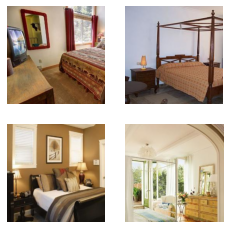

In [11]:
dataloader = DataLoader(dataset, batch_size = batch_size, num_workers = fc.defaults.cpus)
xb = next(iter(dataloader))
show_images(xb[:4], imsize = 2)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)
xe = vae.encode(xb.cuda())
xs = xe.latent_dist.mean[:16]
xd = to_cpu(vae.decode(xs))
npmm_path = Path('data/bedroom/data.npmm')
npmm_shape = (303125, 4, 32, 32)
count = 0
if not npmm_path.exists():
    x = np.memmap(npmm_path, np.float32, mode = 'w+', shape = npmm_shape)
    i = 0
    for b in progress_bar(dataloader):
        n = len(b)
        x[i : i + n] = to_cpu(vae.encode(b.cuda()).latent_dist.mean).numpy()
        i += n
        count += 1
        if count % 2 != 0:
          continue
    a.flush()
    del(a)

lats = np.memmap(npmm_path, dtype = np.float32, mode = 'r', shape = npmm_shape)
xd = to_cpu(vae.decode(b.cuda()))

In [ ]:
def collate_ddpm(b): 
    return noisify(default_collate(b) * 0.2)

n = len(lats)
tds = lats[: n // 10 * 9]
vds = lats[n // 10 * 9 :]
batch_size = 16

dataloaders = DataLoaders(*get_dls(tds, vds, batch_size = batch_size, num_workers = fc.defaults.cpus, collate_fn = collate_ddpm))

(xt, t), eps = b = next(iter(dataloaders.train))

In [ ]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()
    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [ ]:
lr = 5e-3
epochs = 30
opt_func = partial(optim.AdamW, eps = 1e-5)
tmax = epochs * len(dataloaders.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot = True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]

In [ ]:
model = EmbUNetModel(in_channels = 4, out_channels = 4, nfs = (128, 256, 512, 768), num_layers=2, attn_start=1, attn_chans=16)
init_ddpm(model)
learn = Learner(model, dataloaders, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
preds = sample(ddim_step, model, (16, 4, 32, 32), steps = 200, eta = 1., clamp = False)
s = preds[-1] * 5
with torch.no_grad(): 
    pd = to_cpu(vae.decode(s.cuda()))
show_images(pd['sample'][:9].clamp(0,1), imsize = 5)